In [1]:
import numpy as np
import os
home_path = os.path.expanduser("~") + '/'
from utils.load_data import *
from utils.info_params import *

OpenCV is built with OpenMP support. This usually results in poor performance. For details, see https://github.com/tensorpack/benchmarks/blob/master/ImageNet/benchmark-opencv-resize.py


In [2]:
def get_data(hps):
    dfX, df_next_deltaClose = load_data_seq(hps)

    segment, next_segment, target_one_hot = segment_seq(dfX, df_next_deltaClose, hps)

    train_segment, test_segment, _, _, train_target_one_hot, test_target_one_hot = \
        train_test_split(segment, next_segment, target_one_hot, hps)

    return train_segment, test_segment, train_target_one_hot, test_target_one_hot

In [4]:
hps = get_default_hparams()
hps.data_file_name = home_path + "data/ccxt/extra/BTC_USDT_binance_1h.csv"

hps.attributes_normalize_mean = ['Low','Close','Volume','N_buy','N_sell', 'buy_amount_avg','sell_amount_avg','buy_amount_std','sell_amount_std','price_avg','price_std','cost_avg','cost_std','Spread_Open_Close','Spread_High_Low','MA_Close_24','MA_Close_240']

hps.is_concat = False
hps.Tau = 1
hps.T = 1
hps.C = 2
hps.D = (1+hps.is_concat) * len(hps.attributes_normalize_mean)
hps.is_differencing = True
hps.lag_time = 1
hps.N_train_seq = 10000 + hps.T - 1
hps.normalize_data = 'min_max'
hps.normalize_data_idx = True

In [5]:
X_train, X_test, train_target_one_hot, test_target_one_hot = get_data(hps)
X_train = np.reshape(X_train, newshape=[-1, hps.T * hps.D])
X_test = np.reshape(X_test, newshape=[-1, hps.T * hps.D])

y_train = np.argmax(train_target_one_hot, axis=-1)
y_train = np.reshape(y_train, newshape=[-1, hps.Tau])

y_test = np.argmax(test_target_one_hot, axis=-1)
y_test = np.reshape(y_test, newshape=[-1, hps.Tau])

Normalize: Min Max


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [6]:
clf = RandomForestClassifier(random_state=2302, n_estimators=127) #, warm_start = True)
clf.fit(X_train, y_train)

/home/nam/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=127, n_jobs=None,
            oob_score=False, random_state=2302, verbose=0,
            warm_start=False)

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_train_hat = clf.predict(X_train)
cm = confusion_matrix(y_train, y_train_hat)
rp = classification_report(y_train, y_train_hat)
score = accuracy_score(y_train, y_train_hat)

print(cm)
print(rp)
print(score)

[[4838    0]
 [   0 5162]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4838
           1       1.00      1.00      1.00      5162

   micro avg       1.00      1.00      1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

1.0


In [8]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
rp = classification_report(y_test, y_pred)
score = accuracy_score(y_test, y_pred)

print(cm)
print(rp)
print(score)

[[1756 1856]
 [1600 2288]]
              precision    recall  f1-score   support

           0       0.52      0.49      0.50      3612
           1       0.55      0.59      0.57      3888

   micro avg       0.54      0.54      0.54      7500
   macro avg       0.54      0.54      0.54      7500
weighted avg       0.54      0.54      0.54      7500

0.5392


In [9]:
N = 100
y_pred = clf.predict(X_test[:N])
cm = confusion_matrix(y_test[:N], y_pred)
rp = classification_report(y_test[:N], y_pred)
score = accuracy_score(y_test[:N], y_pred)

print(cm)
print(rp)
print(score)

[[23 32]
 [16 29]]
              precision    recall  f1-score   support

           0       0.59      0.42      0.49        55
           1       0.48      0.64      0.55        45

   micro avg       0.52      0.52      0.52       100
   macro avg       0.53      0.53      0.52       100
weighted avg       0.54      0.52      0.52       100

0.52


# Save and Load Model:


In [10]:
# #Saving model
# from sklearn.externals import joblib
# joblib.dump(clf, 'checkpoint/Random_Forest_sklearn.joblib')

['checkpoint/Random_Forest_sklearn.joblib']

In [22]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
y = np.reshape(y, -1)

Automatically created module for IPython interactive environment
Average difference of 0.000682 with std. dev. of 0.001009.


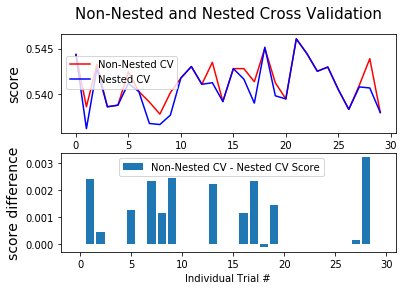

In [28]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np

print(__doc__)

# Number of random trials
NUM_TRIALS = 30

# Set up possible values of parameters to optimize over
p_grid = {"n_estimators": [63,127]}

# We will use a Support Vector Classifier with "rbf" kernel
rf = RandomForestClassifier(random_state=2309)

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=rf, param_grid=p_grid, cv=inner_cv,
                       iid=False)
    clf.fit(X, y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print("Average difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")

plt.show()

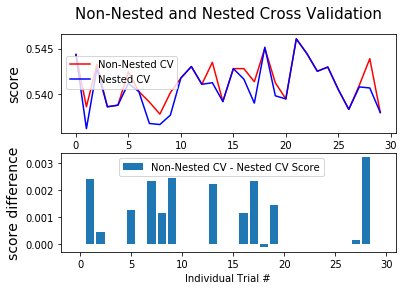

In [40]:
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")
plt.savefig('figures/rf_nested_CV.jpg')
plt.show()

# Save numpy value:

In [34]:
np.savez('checkpoint.npz', non_nested_scores=non_nested_scores, nested_scores=nested_scores,non_nested_scores_line = non_nested_scores_line, nested_line = nested_line )

In [35]:
checkpoint = np.load('checkpoint.npz')

In [36]:
checkpoint['non_nested_scores']

array([0.54434286, 0.53862857, 0.54325714, 0.53862857, 0.5388    ,
       0.54245714, 0.54028571, 0.53914286, 0.53782857, 0.54017143,
       0.54177143, 0.54302857, 0.54108571, 0.54348571, 0.5392    ,
       0.5428    , 0.5428    , 0.54137143, 0.54502857, 0.54125714,
       0.53948571, 0.54605714, 0.54445714, 0.54251429, 0.54297143,
       0.54051429, 0.53834286, 0.54097143, 0.54388571, 0.538     ])